#  <font color="#002d5b">Análise de Série Temporal e Forecasting em Python </font>



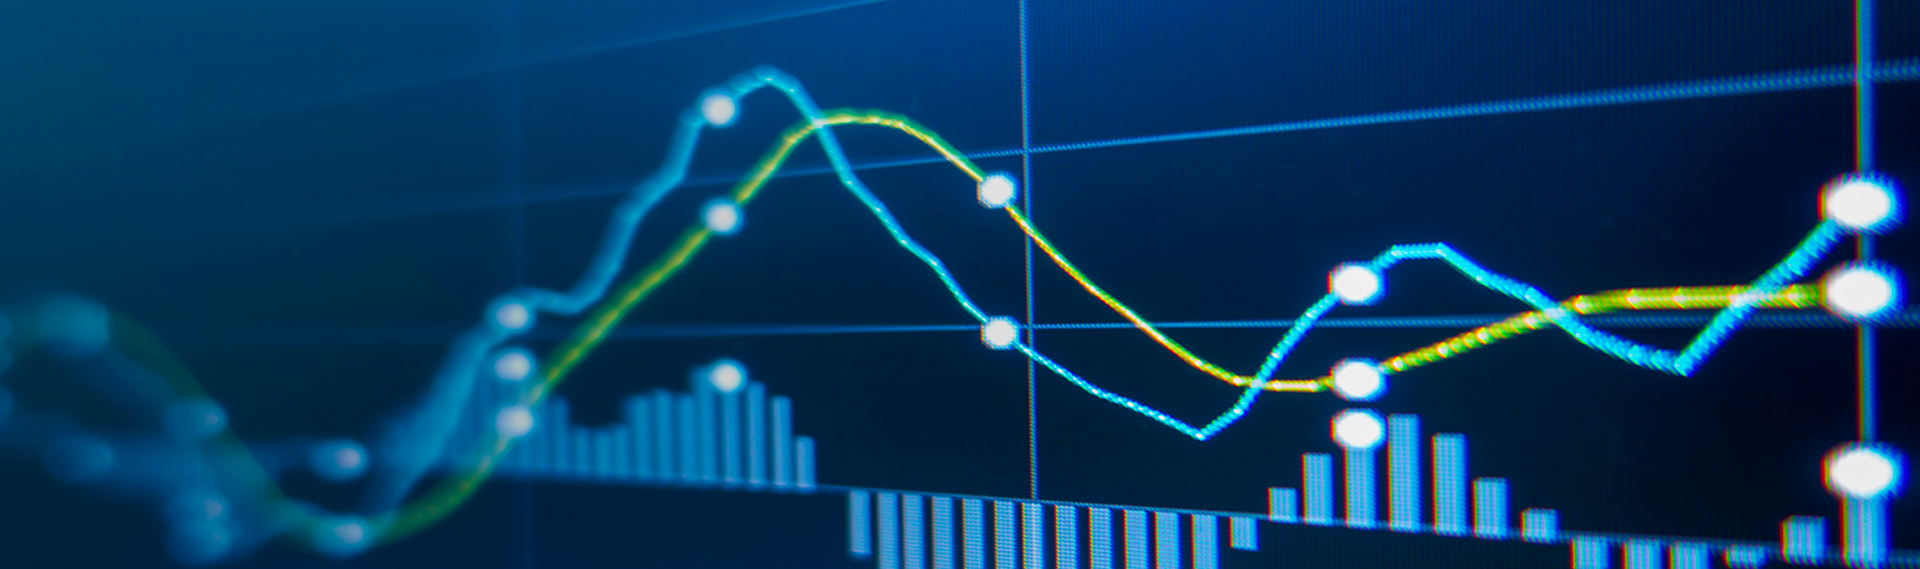

#  <font color="#002d5b">Contexto </font> 


Este projeto explora os dados relacionados à **produção de Cerveja** na Austrália e fornece previsões baseadas em alguns modelos utilizados para a realização do *Casting* nos dados, como **ARIMA** e **LSTM**. Possui dados de uma única série temporal com frequência mensal, representando a produção total de cerveja australiana em megalitros durante o período de janeiro de 1956 a agosto de 1995. Nas primeiras etapas, realizo a leitura e a preparação dos dados, em seguida uma breve Análise dos Dados (EDA). O primeiro passo é traçar a **série temporal** e observar quaisquer características típicas, portanto, uma maneira de representar uma série temporal é assumir que o processo estocástico  pode ser representado como uma combinação de componentes de tendência, sazonalidade e componentes cíclicos. Dessa forma, tentamos quebrar a série nesses componentes, a fim de escolher qual modelo teria melhor desempenho em termos de previsão.

##   <font color="#003366">Leitura dos Dados </font> 

In [16]:
#importando as bibliotecas
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from pandas_profiling import ProfileReport
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor

In [17]:
#Importando o dataset
df = pd.read_csv('monthly-beer-production-in-austria.csv', sep=(','))

In [18]:
#Exibindo os dados
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [19]:
rows, columns = df.shape

print(f'Esse dataset possui {rows} linhas e {columns} colunas')

Esse dataset possui 476 linhas e 2 colunas


In [20]:
#Exibindo 5 amostras aleaórias
df.sample(5)

,Month,Monthly beer production
27,1958-04,81.9
146,1968-03,130.5
67,1961-08,87.1
428,1991-09,138.0
354,1985-07,151.6


In [21]:
#Exibindo os tipos de dados do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


Analisando rapidamente esse conjunto de dados, nota-se que o dataset apresenta um total de **476** linhas, entradas ou observações, bem como um total de apenas **2** colunas. Também podemos observar que o tipo de dado da coluna `Month` está no formato Object, e precisamos que essa coluna esteja no formato Datetime para que possamos realizar nossas análises. Iremos realizar o tratamento dessa coluna mais adiante.

##  <font color="#003366">Preparação dos Dados </font> 

In [22]:
#Renomeando as colunas
df.columns = ['Mes', 'Producao_Mes']

In [23]:
#Convertendo a coluna Mes para o formato Datetime
df['Mes'] = pd.to_datetime(df['Mes'])

In [24]:
#Exibindo 5 amostras aleatórias
df.sample(5)

,Mes,Producao_Mes
10,1956-11-01,100.7
74,1962-03-01,94.3
446,1993-03-01,150.0
362,1986-03-01,141.9
25,1958-02-01,84.4


In [25]:
#Exibindo os tipos de dados do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Mes           476 non-null    datetime64[ns]
 1   Producao_Mes  476 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


In [26]:
#Checando se há dados nulos
df.isna().sum()

Mes             0
Producao_Mes    0
dtype: int64

In [27]:
#Verificando se o dataframe possui dados duplicados
duplicados = df.duplicated().sum()
print(f'O dataframe possui {duplicados} dados duplicados.')

O dataframe possui 0 dados duplicados.


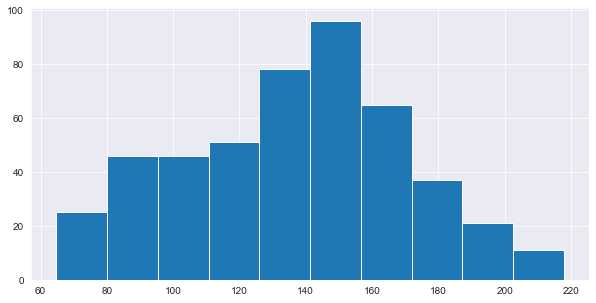

In [28]:
#Histograma 
df.Producao_Mes.hist( figsize=(10,5))
plt.show()

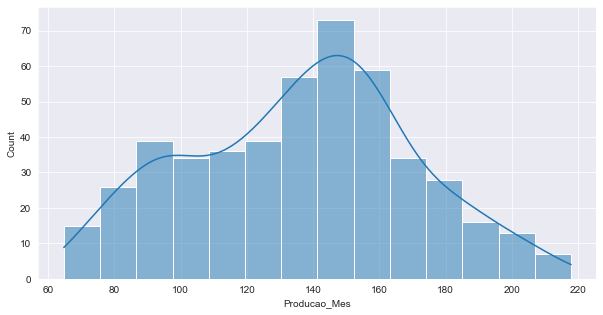

In [29]:
#Histograma 
plt.figure(figsize=(10,5))
sns.histplot(data=df, x="Producao_Mes", kde=True);

In [30]:
fig = px.box(df['Producao_Mes'], title='Box plot da produção mensal de cerveja')
                  
fig.show()          
                  
                  
                



Note que agora após as correções, nossos dados estão com o tipo correto e renomeados para melhor entendimento do dataset. Por meio dos gráficos de histograma e de caixa, notamos que os dados seguem uma distribuição normal e não possuem *outliers* e nem dados ausentes ou duplicados. É possível observar que a produção mensal de cerveja na Austrália está, em sua maior parte, no intervalo de **112** a **158** megalitros. 

In [31]:
#Transformando a coluna Mes em Indice
df = df.set_index(['Mes']) 

In [32]:
df.head()

,Producao_Mes
Mes,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


 Também setamos a coluna `Mes` como índice, isso irá nos auxiliar durante a análise de série temporal. A partir de agora iremos explorar esses dados e realizar as devidas análises.

##  <font color="#003366">Análise Exploratória </font> 

In [33]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [34]:
#Exibindo as estatísticas descritivas dos dados
df.describe()

,Producao_Mes
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


In [35]:
#Exibindo a data mais antiga e a data mais recente do dataframe
df.index.min(), df.index.max()

(Timestamp('1956-01-01 00:00:00'), Timestamp('1995-08-01 00:00:00'))

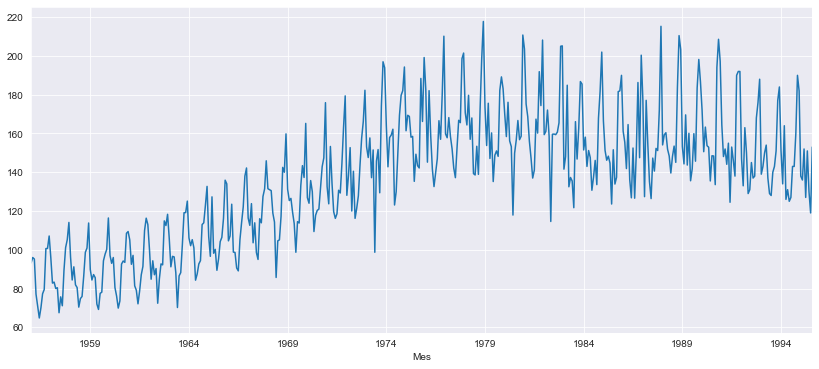

In [36]:
#Gráfico p/ uma visualização mais simples
df['Producao_Mes'].plot(figsize= (14, 6));

In [37]:
#Plotagem mais elaborada e interativa com Plotly Express
fig = px.line(df, title='Produção de Cerveja ao longo dos anos na Austrália',
               labels={
                     "Mes": "Anos",
                     "value": "Produção",
                     "variable":"Variável"
                       }
              )

fig.show()

Ao plotarmos os dados no gráfico de linha, podemos identificar imediatamente duas coisas:
   * padrões de repetição em frequências regulares  - Componente que indica **sazonalidade**
   * **tendência linear ascendente** em cerca do ano 1975, e uma mudança estrutural posteriormente. Para o resto do período, parece não haver componente de tendência.

In [38]:
fig = px.line(df, title='Série temporal com controle deslizante de intervalo e seletores', 
             labels={
                 'variable':'Variável',
                 'value': 'Produção',
                 'Mes':'Período'
             }
           
             )

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

Os dados desse dataset são mensais, portanto é seguro assumir que a sazonalidade é de cerca de um ano (**12 meses**). Um gráfico rápido exibindo a **média móvel** de 12 meses confirma essa suposição e visualiza o componente de tendência da série. Também podemos ver que os picos sazonais aumentam com o tempo, o que é indicativo de **sazonalidade multiplicativa**.

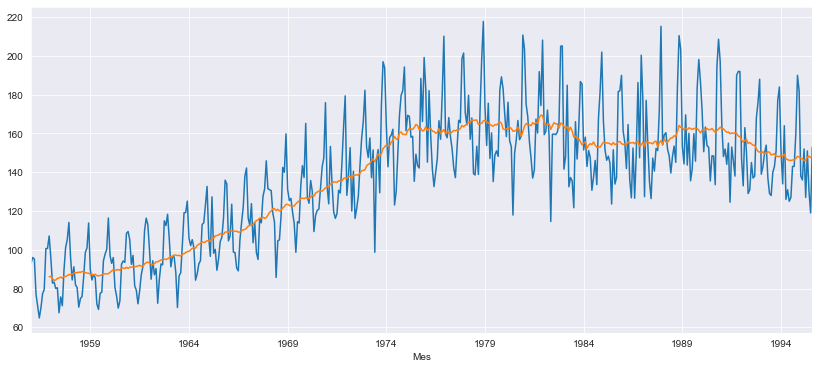

In [39]:
#Gráfico exibindo a Média Móvel de 12 meses, rolling(12).
plt.figure(figsize=(14,6))

df['Producao_Mes'].plot();
df['Producao_Mes'].rolling(12).mean().plot();

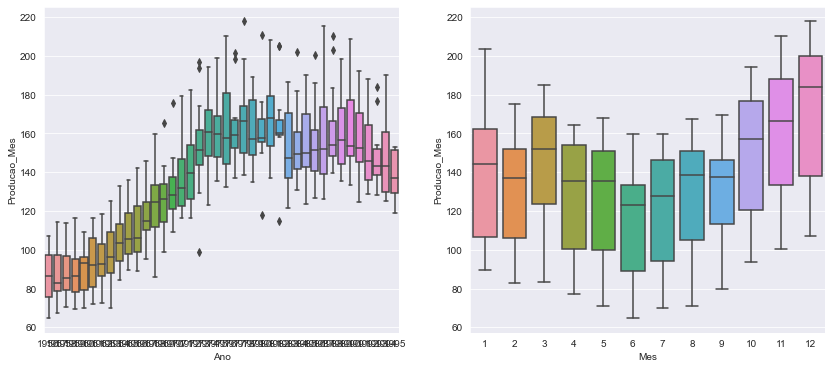

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

#Criando uma cópia do dataframe
sns_graf = df.copy()

sns_graf['Ano'] = sns_graf.index.year
sns_graf['Mes'] = sns_graf.index.month

#Plotando os boxplots
sns.boxplot(x="Ano", y="Producao_Mes", data=sns_graf, ax = axes[0]);
sns.boxplot(x="Mes", y="Producao_Mes", data=sns_graf, ax = axes[1]);

Observe que também podemos visualizar a tendência e os componentes sazonais utilizando boxplots. Note que os meses de menor produção de cerveja são **maio**, **junho** e **julho**, que também correspondem ao inverno australiano.

##  <font color="#003366"> Prevendo com ARIMA </font>

**ARIMA** é um modelo usado para prever tendências futuras em dados de série temporal. É um modelo do tipo análise de regressão.

* **AR** (Autoregression) : Modelo que mostra uma variável em mudança que regride em seus próprios valores defasados/ anteriores.
* **I** (Integrated) : Diferenciação de observações brutas para permitir que a série temporal se torne estacionária
* **MA** (Moving average) : Dependência entre uma observação e um erro residual de um modelo de média móvel


Para modelos ARIMA, uma notação padrão seria ARIMA com p, d e q, onde valores inteiros substituem os parâmetros para indicar o tipo de modelo ARIMA usado, onde:

* **p**: o número de observações de defasagem (lag) no modelo; também conhecido como ordem de latência (lag order).
* **d**: o número de vezes que as observações brutas são diferenciadas; também conhecido como grau de diferenciação.
* **q**: o tamanho da janela de média móvel; também conhecido como a ordem da média móvel. 

In [41]:
#Importando a biblioteca seasonal_decompose p/ decompor os dados
from statsmodels.tsa.seasonal import seasonal_decompose

Podemos usar o método `seasonal_decompose` para decompor nossos dados e explorar ainda mais a divisão da série em seus respectivos componentes.

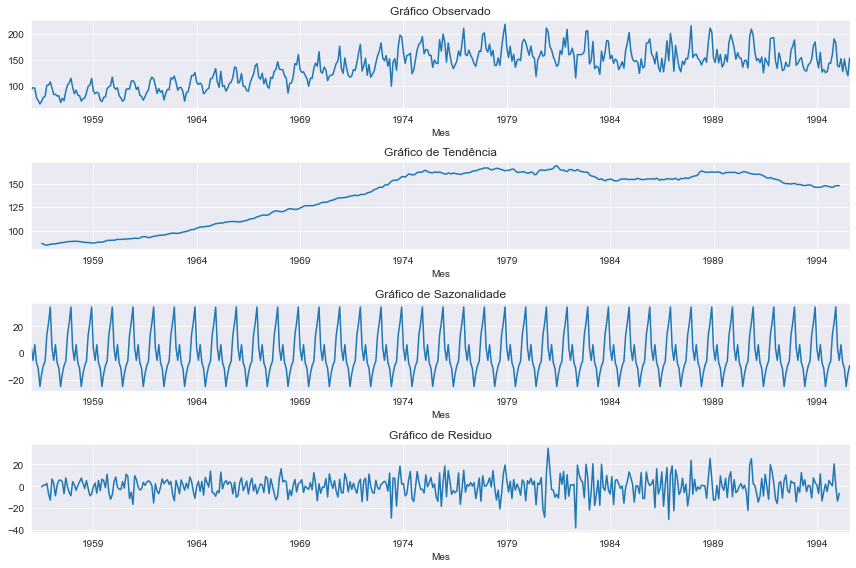

In [42]:
#Visualização simples 
resultado = seasonal_decompose(df)

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(12,8))


resultado.observed.plot(ax=ax1, title='Gráfico Observado')

resultado.trend.plot(ax=ax2, title='Gráfico de Tendência')

resultado.seasonal.plot(ax=ax3, title='Gráfico de Sazonalidade')

resultado.resid.plot(ax=ax4, title='Gráfico de Residuo')

plt.tight_layout()




In [43]:
#Visualização Interativa com plotly.graph_objects go
resultado = seasonal_decompose(df)


fig = make_subplots(rows=4, cols=1)

fig.add_trace(go.Scatter(x=df.index, y=df["Producao_Mes"],
                                name="Gráfico Observado",
                                mode='lines'),
                                 row=1,
                                 col=1)

fig.add_trace(go.Scatter(x=df.index, y=resultado.trend,
                                name="Tendência",
                                mode='lines'),
                                 row=2,
                                 col=1)

fig.add_trace(go.Scatter(x=df.index, y=resultado.seasonal,
                                name="Sazonalidade",
                                mode='lines'),
                                 row=3,
                                 col=1)


fig.add_trace(go.Scatter(x=df.index, y=resultado.resid,
                                name="Resíduos",
                                mode='lines'),
                                 row=4,
                                 col=1)

fig.show()

###  <font color="#003366"> Teste de Estacionariedade</font>



Ao analisarmos os gráficos, já é possível notar que os dados são obviamente não estacionários seguindo um processo AR (1) que não oscila em torno de seu valor âncora inicial. Dessa forma, isso pode ser mostrado pelos resultados do teste de **Dickey-Fuller** que confirma que com um nível de significância de **5%** a série de produção de cerveja não é estacionária.

In [44]:
#Importando a biblioteca 
from statsmodels.tsa.stattools import adfuller

#Realizando o Teste Dickey-Fuller
resultado = adfuller(df['Producao_Mes'].dropna())
print(f'Teste ADF: {resultado[0]}')
print(f'p-Valor: {resultado[1]}')
print('Valores Críticos:')
for key, value in resultado[4].items():
    print('\t%s: %.3f' % (key, value))



Teste ADF: -2.282661418787567
p-Valor: 0.17762099829132838
Valores Críticos:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [45]:
#diff () Calcula a diferença de um elemento dataframe
from statsmodels.tsa.stattools import adfuller

resultado = adfuller(df['Producao_Mes'].diff().dropna())
print(f'Teste ADF: {resultado[0]}')
print(f'p-Valor: {resultado[1]}')

Teste ADF: -4.980663743065011
p-Valor: 2.4234117859936578e-05


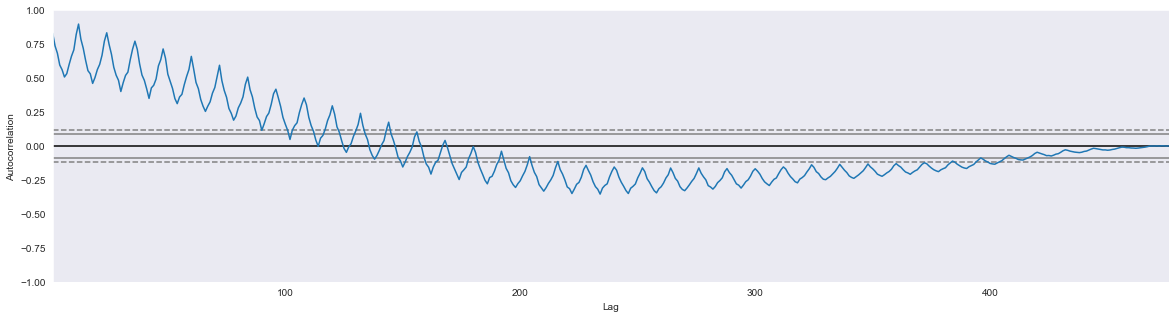

In [46]:
#Exibindo gráfico de autocorrelação
plt.figure(figsize=(20,5))

pd.plotting.autocorrelation_plot(df['Producao_Mes']);

    
  

A função de autocorrelação simples dá indicações de que a série não é estacionária e verifica o teste de raiz unitária.

In [47]:
#Auto ARIMA nos ajuda a buscar os melhores parâmetros
fit_arima = auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True,
                       m=6,
                       D=1,
                       start_P=1,
                       start_Q=1,
                       max_P=2,
                       max_Q=2,
                       information_criterion='aic',
                       trace=True,
                       error_action='ignore',
                       stepwise=True
                      
                      )

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=3667.083, Time=3.35 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=4549.066, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=3909.258, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=0.92 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=inf, Time=1.54 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=3687.775, Time=2.21 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=inf, Time=6.06 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=3536.571, Time=5.78 sec
 ARIMA(1,1,1)(0,1,2)[6]             : AIC=3958.026, Time=4.69 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=3521.625, Time=7.12 sec
 ARIMA(0,1,1)(2,1,2)[6]             : AIC=inf, Time=6.51 sec
 ARIMA(1,1,0)(2,1,2)[6]             : AIC=inf, Time=6.04 sec
 ARIMA(2,1,1)(2,1,2)[6]             : AIC=3509.218, Time=7.69 sec
 ARIMA(2,1,1)(1,1,2)[6]             : AIC=3518.880, Time=7.62 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=inf, Time=7.20 s

 Agora que sabemos quais são os melhores parâmetros, vamos criar um modelo **SARIMAX** (versão do Arima com parametros para sazonalidade).


In [48]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

modelo = SARIMAX(df, order=(2, 1, 1), seasonal_order=(2, 1, 2, 6))
resultado_sarimax = modelo.fit()

C:\Users\Gamova011\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Gamova011\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Gamova011\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [49]:
# resultados do modelo SARIMAX(2,1,2, 6)
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                           Producao_Mes   No. Observations:                  476
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 6)   Log Likelihood               -1746.609
Date:                                Wed, 13 Oct 2021   AIC                           3509.218
Time:                                        10:51:34   BIC                           3542.423
Sample:                                    01-01-1956   HQIC                          3522.283
                                         - 08-01-1995                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1808      0.040     -4.490      0.000      -0.260      -0.102
ar.L2         -0.1905      0.043     -4.408      0.000      -0.275      -0.106
ma.L1         -0.8658      0.026    -33.798      0.000      -0.916      -0.816
ar.S.L6       -0.7943      0.053    -15.041      0.000      -0.898      -0.691
ar.S.L12       0.2043      0.052      3.899      0.000       0.102       0.307
ma.S.L6       -0.0506      0.037     -1.351      0.177      -0.124       0.023
ma.S.L12      -0.8265      0.030    -27.708      0.000      -0.885      -0.768
sigma2        93.6412      4.990     18.766      0.000      83.861     103.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                46.67
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.40   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

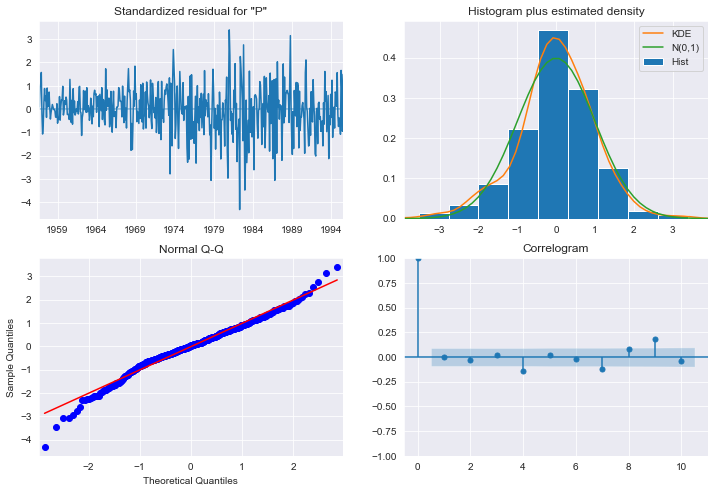

In [50]:
#Gráficos com os diagnosticos do modelo Sarimax
resultado_sarimax.plot_diagnostics(figsize=(12,8))
plt.show()

Observe que todos os 4 gráficos parecem indicar um bom ajuste do **modelo SARIMA** na série temporal fornecida.

In [51]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = resultado_sarimax.get_prediction(start= -12)
predicao_media = predicoes.predicted_mean

In [52]:
#Intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]


(117.70684469391708, 155.6394361443253)

In [53]:
predicao_media[0]

136.67314041912118

In [54]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df.index)

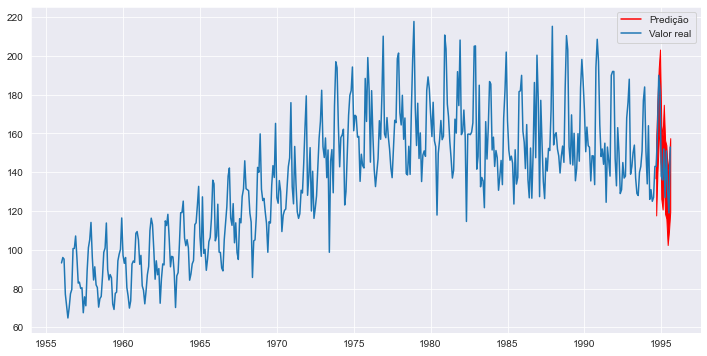

In [55]:
#Gráfico de linhas exibindo os valores da predicao e os valores reais
fig = plt.figure(figsize = (12, 6))
plt.plot(datas_previsao, predicao_media.values, color='red', label = 'Predição')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, df.values, label='Valor real')
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import mean_squared_error

from math import sqrt

rmse_sarima = sqrt(mean_squared_error(df[-12:].values, predicao_media.values))
print(rmse_sarima)

9.52446825914367


## <font color="#003366"> Forecast com ARIMA </font>


*Forecasting* é a técnica de encontrar **padrões** e **tendências** para tentar prever eventos futuros, com base no histórico de dados no tempo. É um conceito bem parecido com análise supervisionada, mas com a variável temporal. No exemplo a seguir faremos um Forecast utilizando ARIMA.


In [174]:
# Forecast ARIMA para 12 valores

forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
forecast_medio.size

12

In [175]:
#configurando os intervalos de confiança
intervalo_confianca_forecast = forecast.conf_int()
intervalo_abaixo_f = intervalo_confianca_forecast.iloc[:,0]
intervalo_acima_f = intervalo_confianca_forecast.iloc[:,1]

intervalo_abaixo_f[10], intervalo_acima_f[10]

(110.90246631205821, 151.69343826392333)

In [176]:
forecast_medio[10]

131.29795228799077

In [177]:
datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(predicao_media.index)

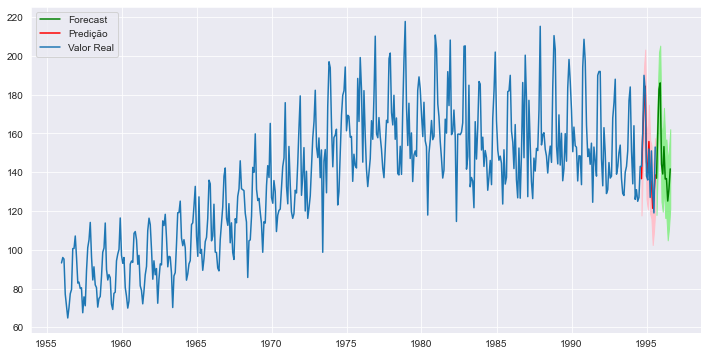

In [178]:
#Gráfico exibindo os valores da Predição, do Forecast e o valor real
dates=np.asarray(df.index)
plt.figure(figsize=(12,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='Forecast')
plt.fill_between(datas_forecast, intervalo_abaixo_f, intervalo_acima_f, color='lightgreen')

plt.plot(datas_previsao,predicao_media.values,color='red',label='Predição')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='pink')

plt.plot(dates,df.values, label='Valor Real')
plt.legend(loc='upper left')
plt.show()

In [204]:
#Separando os dados de treino e teste
treino1= df[:len(df)-12]
teste1 = df[len(df)-12:]

In [205]:
#Setando o modelo criado anteriormente no Auto Arima
arima_modelo = modelo
arima_resultado = arima_modelo.fit()
arima_resultado.summary()

C:\Users\Gamova011\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                           Producao_Mes   No. Observations:                  476
Model:             SARIMAX(2, 1, 1)x(2, 1, [1, 2], 6)   Log Likelihood               -1746.609
Date:                                Wed, 13 Oct 2021   AIC                           3509.218
Time:                                        14:21:50   BIC                           3542.423
Sample:                                    01-01-1956   HQIC                          3522.283
                                         - 08-01-1995                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1808      0.040     -4.490      0.000      -0.260      -0.102
ar.L2         -0.1905      0.043     -4.408      0.000      -0.275      -0.106
ma.L1         -0.8658      0.026    -33.798      0.000      -0.916      -0.816
ar.S.L6       -0.7943      0.053    -15.041      0.000      -0.898      -0.691
ar.S.L12       0.2043      0.052      3.899      0.000       0.102       0.307
ma.S.L6       -0.0506      0.037     -1.351      0.177      -0.124       0.023
ma.S.L12      -0.8265      0.030    -27.708      0.000      -0.885      -0.768
sigma2        93.6412      4.990     18.766      0.000      83.861     103.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                46.67
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               3.40   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [206]:
#realizando a predição
arima_pred = arima_resultado.predict(start = len(treino1), end = len(df)-1, typ="levels").rename("Predição com ARIMA")
arima_pred

1994-09-01    136.673140
1994-10-01    158.848214
1994-11-01    174.904773
1994-12-01    184.358360
1995-01-01    145.252192
1995-02-01    139.733239
1995-03-01    155.853305
1995-04-01    137.478477
1995-05-01    134.987724
1995-06-01    121.398084
1995-07-01    128.274889
1995-08-01    138.639807
Freq: MS, Name: Predição com ARIMA, dtype: float64

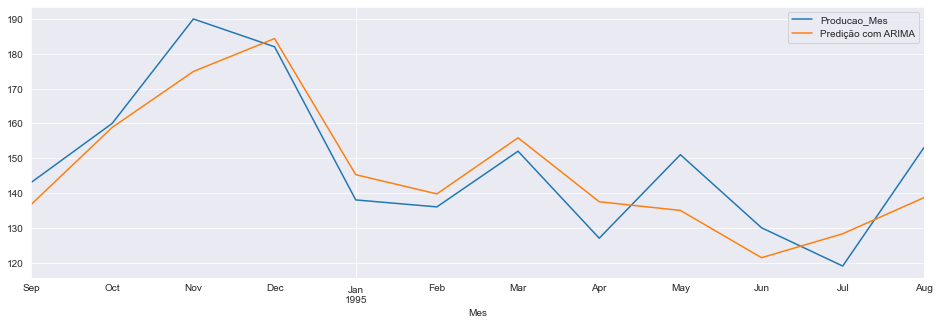

In [207]:
#Gráfico exibindo a produção real e sua predição com ARIMA
teste1['Producao_Mes'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [208]:
arima_rmse_error = rmse(teste1['Producao_Mes'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['Producao_Mes'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 90.71549561943526
RMSE Error: 9.52446825914367
Mean: 136.39537815126045


In [209]:
teste1['ARIMA_Predicao'] = arima_pred

##   <font color="#003366"> Forecast com LSTM </font>

**LSTM** (Long Short-Term Memory) é uma arquitetura baseada em Rede Neural Recorrente (RNN) que é amplamente usada no processamento de linguagem natural e previsão de séries temporais. 

In [254]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [255]:
treino= df[:len(df)-12]
teste = df[len(df)-12:]

In [256]:
#Treinando o modelo de treino e teste
scaler.fit(treino)
scaled_train_data = scaler.transform(treino)
scaled_test_data = scaler.transform(teste)

In [257]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [258]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [260]:
lstm_model.fit_generator(generator,epochs=20)

C:\Users\Gamova011\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/20
452/452 [==============================] - 5s 8ms/step - loss: 0.0241
Epoch 2/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0130
Epoch 3/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0096
Epoch 4/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0088
Epoch 5/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0081
Epoch 6/20
452/452 [==============================] - 4s 9ms/step - loss: 0.0074
Epoch 7/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0069
Epoch 8/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0077
Epoch 9/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0066
Epoch 10/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0075
Epoch 11/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0068
Epoch 12/20
452/452 [==============================] - 4s 8ms/step - loss: 0.0067
Epoch 13/20
452/452 [====

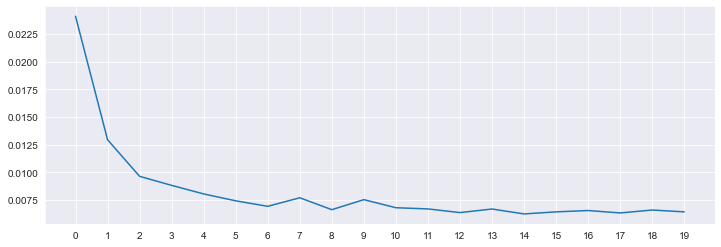

In [261]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [262]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(teste)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [263]:
lstm_predictions_scaled

[array([0.52571285], dtype=float32),
 array([0.5907838], dtype=float32),
 array([0.69036204], dtype=float32),
 array([0.69972783], dtype=float32),
 array([0.5641204], dtype=float32),
 array([0.52797097], dtype=float32),
 array([0.58878064], dtype=float32),
 array([0.45183516], dtype=float32),
 array([0.45360658], dtype=float32),
 array([0.42887905], dtype=float32),
 array([0.45155454], dtype=float32),
 array([0.5126811], dtype=float32)]

In [264]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

In [265]:
lstm_predictions

array([[145.2340657 ],
       [155.18991755],
       [170.42539154],
       [171.85835849],
       [151.11042302],
       [145.57955836],
       [154.88343816],
       [133.93077879],
       [134.20180609],
       [130.41849502],
       [133.88784413],
       [143.24021237]])

In [266]:
teste1['LSTM_Predictions'] = lstm_predictions

In [267]:
teste1

,Producao_Mes,ARIMA_Predicao,LSTM_Predictions
Mes,,,
1994-09-01,143.0,136.673140,145.234066
1994-10-01,160.0,158.848214,155.189918
1994-11-01,190.0,174.904773,170.425392
1994-12-01,182.0,184.358360,171.858358
1995-01-01,138.0,145.252192,151.110423
1995-02-01,136.0,139.733239,145.579558
1995-03-01,152.0,155.853305,154.883438
1995-04-01,127.0,137.478477,133.930779
1995-05-01,151.0,134.987724,134.201806


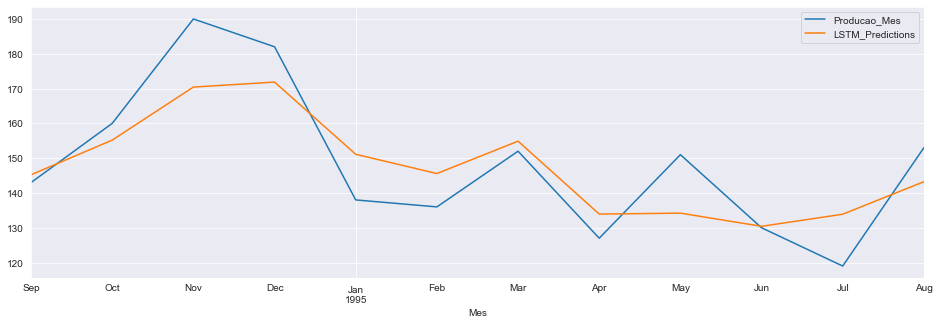

In [268]:
teste1['Producao_Mes'].plot(figsize = (16,5), legend=True)
teste1['LSTM_Predictions'].plot(legend = True);

In [269]:
from statsmodels.tools.eval_measures import rmse

lstm_rmse_error = rmse(teste1['Producao_Mes'], teste1["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['Producao_Mes'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 119.45024884496628
RMSE Error: 10.92932975277836
Mean: 136.39537815126045


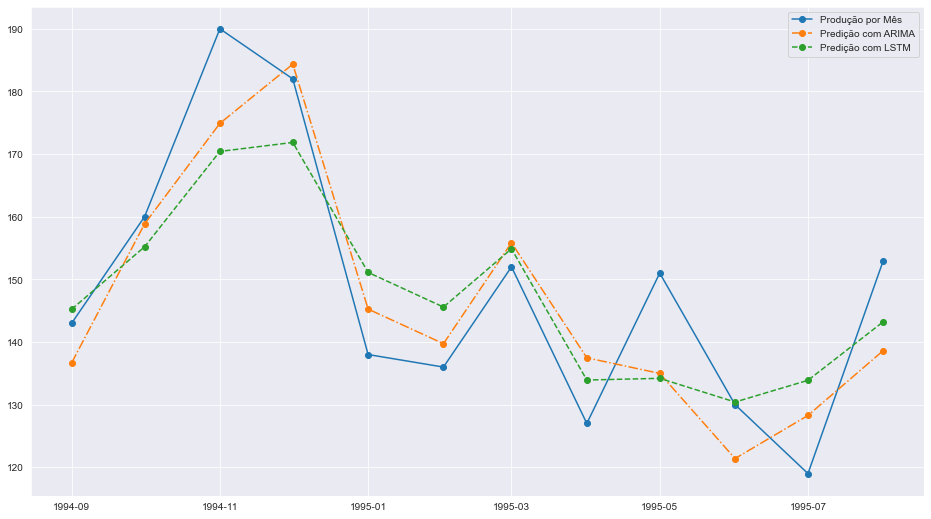

In [270]:
#Gráfico exibindo a produção real, predição com ARIMA e predição com LSTM
plt.figure(figsize=(16,9))
plt.plot_date(teste1.index, teste1['Producao_Mes'], linestyle="-", label='Produção por Mês')
plt.plot_date(teste1.index, teste1["ARIMA_Predicao"], linestyle="-.", label='Predição com ARIMA')
plt.plot_date(teste1.index, teste1["LSTM_Predictions"], linestyle="--", label='Predição com LSTM')

plt.legend()
plt.show()

In [271]:
rmse_errors = [arima_rmse_error, lstm_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})

In [272]:
errors

,Models,RMSE Errors,MSE Errors
0,ARIMA,9.524468,90.715496
1,LSTM,10.929330,119.450249


In [273]:
teste1

,Producao_Mes,ARIMA_Predicao,LSTM_Predictions
Mes,,,
1994-09-01,143.0,136.673140,145.234066
1994-10-01,160.0,158.848214,155.189918
1994-11-01,190.0,174.904773,170.425392
1994-12-01,182.0,184.358360,171.858358
1995-01-01,138.0,145.252192,151.110423
1995-02-01,136.0,139.733239,145.579558
1995-03-01,152.0,155.853305,154.883438
1995-04-01,127.0,137.478477,133.930779
1995-05-01,151.0,134.987724,134.201806


Após a realização dos Forecastings, podemos observar que o modelo ARIMA obteve melhores resultados nas predições dos dados. Entretanto, esse é apenas um modelo básico de predição, dependendo do tipo de ajuste a ser realizado nos modelos, podemos obter resultados mais satisfatórios.